## In silico perturbation for GRN prediction

### The GRN prediction is based on the cosine similarity of gene embeddings between origin state and in silico perturbed state. By comparing the cosine similarity among genes except for the TF, those with low cosine similarity genes are prone to be considered as Target Genes (TG).

In [2]:
from genecompass.utils import load_prior_embedding
from genecompass.perturb_delete_chipseq import InSilicoPerturber
import tqdm
import pickle
import os
import sys
sys.path.append("../")
TOKEN_DICTIONARY_FILE = '../prior_knowledge/human_mouse_tokens.pickle'
out = load_prior_embedding(token_dictionary_or_path=TOKEN_DICTIONARY_FILE)

knowledges = dict()
knowledges['promoter'] = out[0]
knowledges['co_exp'] = out[1]
knowledges['gene_family'] = out[2]
knowledges['peca_grn'] = out[3]
knowledges['homologous_gene_human2mouse'] = out[4]

ModuleNotFoundError: No module named 'genecompass'

### To obtain the cosine similarity, the in silico perturbation of TFs is performed.

In [ ]:
with open("../data/insilico_perturbation/ids_in_chip_remain.pickle", "rb") as f:
    tfs = pickle.load(f)
with open("../data/insilico_perturbation/id2name.pickle", "rb") as f:
    id2name = pickle.load(f)
tfs = list(tfs)
for i in tqdm.tqdm(range(len(tfs))):
    isp = InSilicoPerturber(perturb_type="delete",
                            perturb_rank_shift=None,
                            genes_to_perturb=[tfs[i]],
                            combos=0,
                            anchor_gene=None,
                            num_classes=0,
                            emb_mode="cell_and_gene",
                            #emb_mode="gene",
                            cell_emb_style="mean_pool",
                            filter_data=None,
                            cell_states_to_model=None,
                            max_ncells=None,
                            emb_layer=-1,
                            forward_batch_size=10,
                            nproc=4,
                            save_raw_data=False)
    dir_path = f"/output_path/{id2name[tfs[i]]}/"
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    isp.perturb_data("../pretrained_models/GeneCompass_Base",   #path of pretrained or fine-tuned model
                     "../path/",  #preprocessed input data
                     dir_path,    #output
                     "Delete")    #

print("Finished!")

### After obtaining the cosine similarity of perturbing TFs, the top $k$ genes with low cosine similarity are chosen as TGs, where $k$ equals to the ground-truth number.

In [9]:
import pickle
from statistics import median, mean
import pandas as pd
import os
from tqdm import tqdm
with open("../data/insilico_perturbation/id2name.pickle", "rb") as f:
    id2name = pickle.load(f)
with open("../data/insilico_perturbation/name2id.pickle", "rb") as f:
    name2id = pickle.load(f)
def get_subdirectories(path):
    subdirectories = []
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            subdirectories.append(item_path)
    return subdirectories
# output path of last step
folder_path = "/path/of/perturbation"
with open("../data/insilico_perturbation/genes_in_blood.pickle","rb")as f:
    blood = pickle.load(f)
full_results = {}
random_results = {}
for result_dir in tqdm(os.listdir(folder_path)):
    gene_name = result_dir.split(".")[0]
    if gene_name in blood:
        try:
            # path of chip_atlas ground-truth file, ends with .tsv. It can be downloaded from https://chip-atlas.org/target_genes
            df = pd.read_csv(f'/path/of/chip_atlas/{gene_name}.10.tsv', delimiter='\t')
        except:
            continue
        target_genes = set(df['Target_genes'].values)
        with open(str(folder_path+result_dir),"rb")as f:
            data = pickle.load(f)
        data = dict(sorted(data.items(), key=lambda x: x[1], reverse=False))
        sorted_genes = []
        sorted_genes_names = []
        for item in list(data.keys()):
            sorted_genes.append(item[1])
        for item in list(sorted_genes):
            if item in list(id2name.keys()):
                sorted_genes_names.append(id2name[item])

        if len(target_genes)>len(sorted_genes_names):
            inter = set(sorted_genes_names) & set(target_genes)
            numb = len(inter)
            full_results[gene_name] = numb / len(sorted_genes_names)
        else:
            inter = set(sorted_genes_names[:len(target_genes)]) & set(target_genes)
            numb = len(inter)
            full_results[gene_name] = numb / len(target_genes)

        random_results[gene_name] = len(target_genes)/23115


  0%|          | 0/806 [00:00<?, ?it/s]

100%|██████████| 806/806 [16:00<00:00,  1.19s/it]


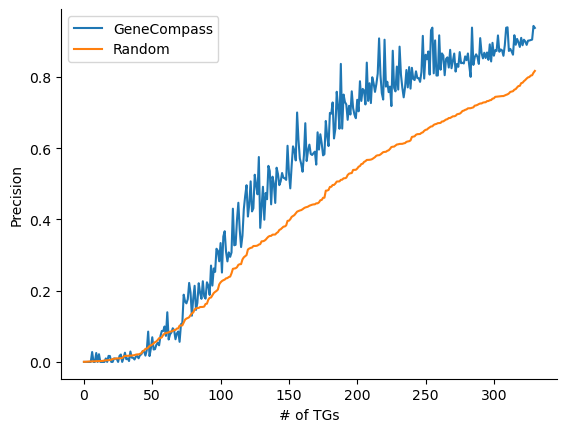

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

random_results = dict(sorted(random_results.items(), key=lambda x: x[1], reverse=False))
names = list(random_results.keys())
random_values = list(random_results.values())
pre_values = [full_results[item] for item in names]

fig, ax = plt.subplots()
x = np.arange(len(list(pre_values)))

ax.plot(x, pre_values, label="GeneCompass")
ax.plot(x, random_values, label="Random")

ax.set_ylabel('Precision')
ax.set_xlabel('# of TGs')
ax.legend(loc='upper left')

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()